## Load Libraries

In [397]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
import datetime as dt
import tensorflow as tf
import keras
from keras.layers import Input,Dropout,Dense,LSTM,TimeDistributed,RepeatVector
from keras.models import Model
from keras import regularizers

In [405]:
import seaborn as sns

## Read data

In [188]:
notifications=pd.read_excel(r"...../SAP_Notifications.xlsm",sheet_name="Notifications")
confirmation=pd.read_excel(r"......../SAP_WO_Confirmations.xlsm",sheet_name="Confirmations")
operations=pd.read_excel(r"......../SAP_WO_Operations_IW37.xlsm",sheet_name="Operations")
price=pd.read_excel(r"......../SAP_WO.xlsm",sheet_name="SAPIW38Data")
tanks=pd.read_excel(r"......./tanks.xlsx")


## Data preparation

In [271]:
######################## tanks notification ########################

In [303]:
tanks_notification=pd.merge(notifications,tanks,on=['Equipment'],how='outer')
tanks_notification=tanks_notification.dropna(subset=['Equipment']).reset_index(drop=True)
tanks_notification=tanks_notification.dropna(subset=['Notif.date']).reset_index(drop=True)
with_time=pd.merge(operations,tanks,on=['Equipment'],how='left')
with_time=with_time.dropna(subset=['Actual finish (date)']).reset_index(drop=True)
with_time=with_time.dropna(subset=['Manufacturer of asset']).reset_index(drop=True)
tanks_notification['Order']=tanks_notification['Order'].astype('int')
with_time['Order']=with_time['Order'].astype('int')

In [304]:
g=pd.merge(tanks_notification,with_time,on=['Order'],how='left')
g=g.dropna(subset=['Actual finish (date)']).reset_index(drop=True)

In [314]:
data_for_anomaly=g[['Notif.date','Equipment_x','Actual finish (date)']]
data_for_anomaly['Difference']=
    (data_for_anomaly['Actual finish (date)'] - data_for_anomaly['Notif.date']).dt.days



/Users/soujanyasamineni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [316]:
data_for_anomaly=data_for_anomaly[['Notif.date','Equipment_x','Difference']]

## Pivot the table

In [337]:
t1=data_for_anomaly.pivot_table(values='Difference', index='Notif.date', 
                             columns='Equipment_x', aggfunc=[np.mean],fill_value=0)

In [344]:
flattened_t1 = pd.DataFrame(t1.to_records())

In [347]:
flattened_t1.columns = [i.replace("('mean', ", "").replace(")", "") \
                     for i in flattened_t1.columns]

In [362]:
f1=flattened_t1.iloc[:,:10]

In [367]:
f1=f1.set_index('Notif.date')

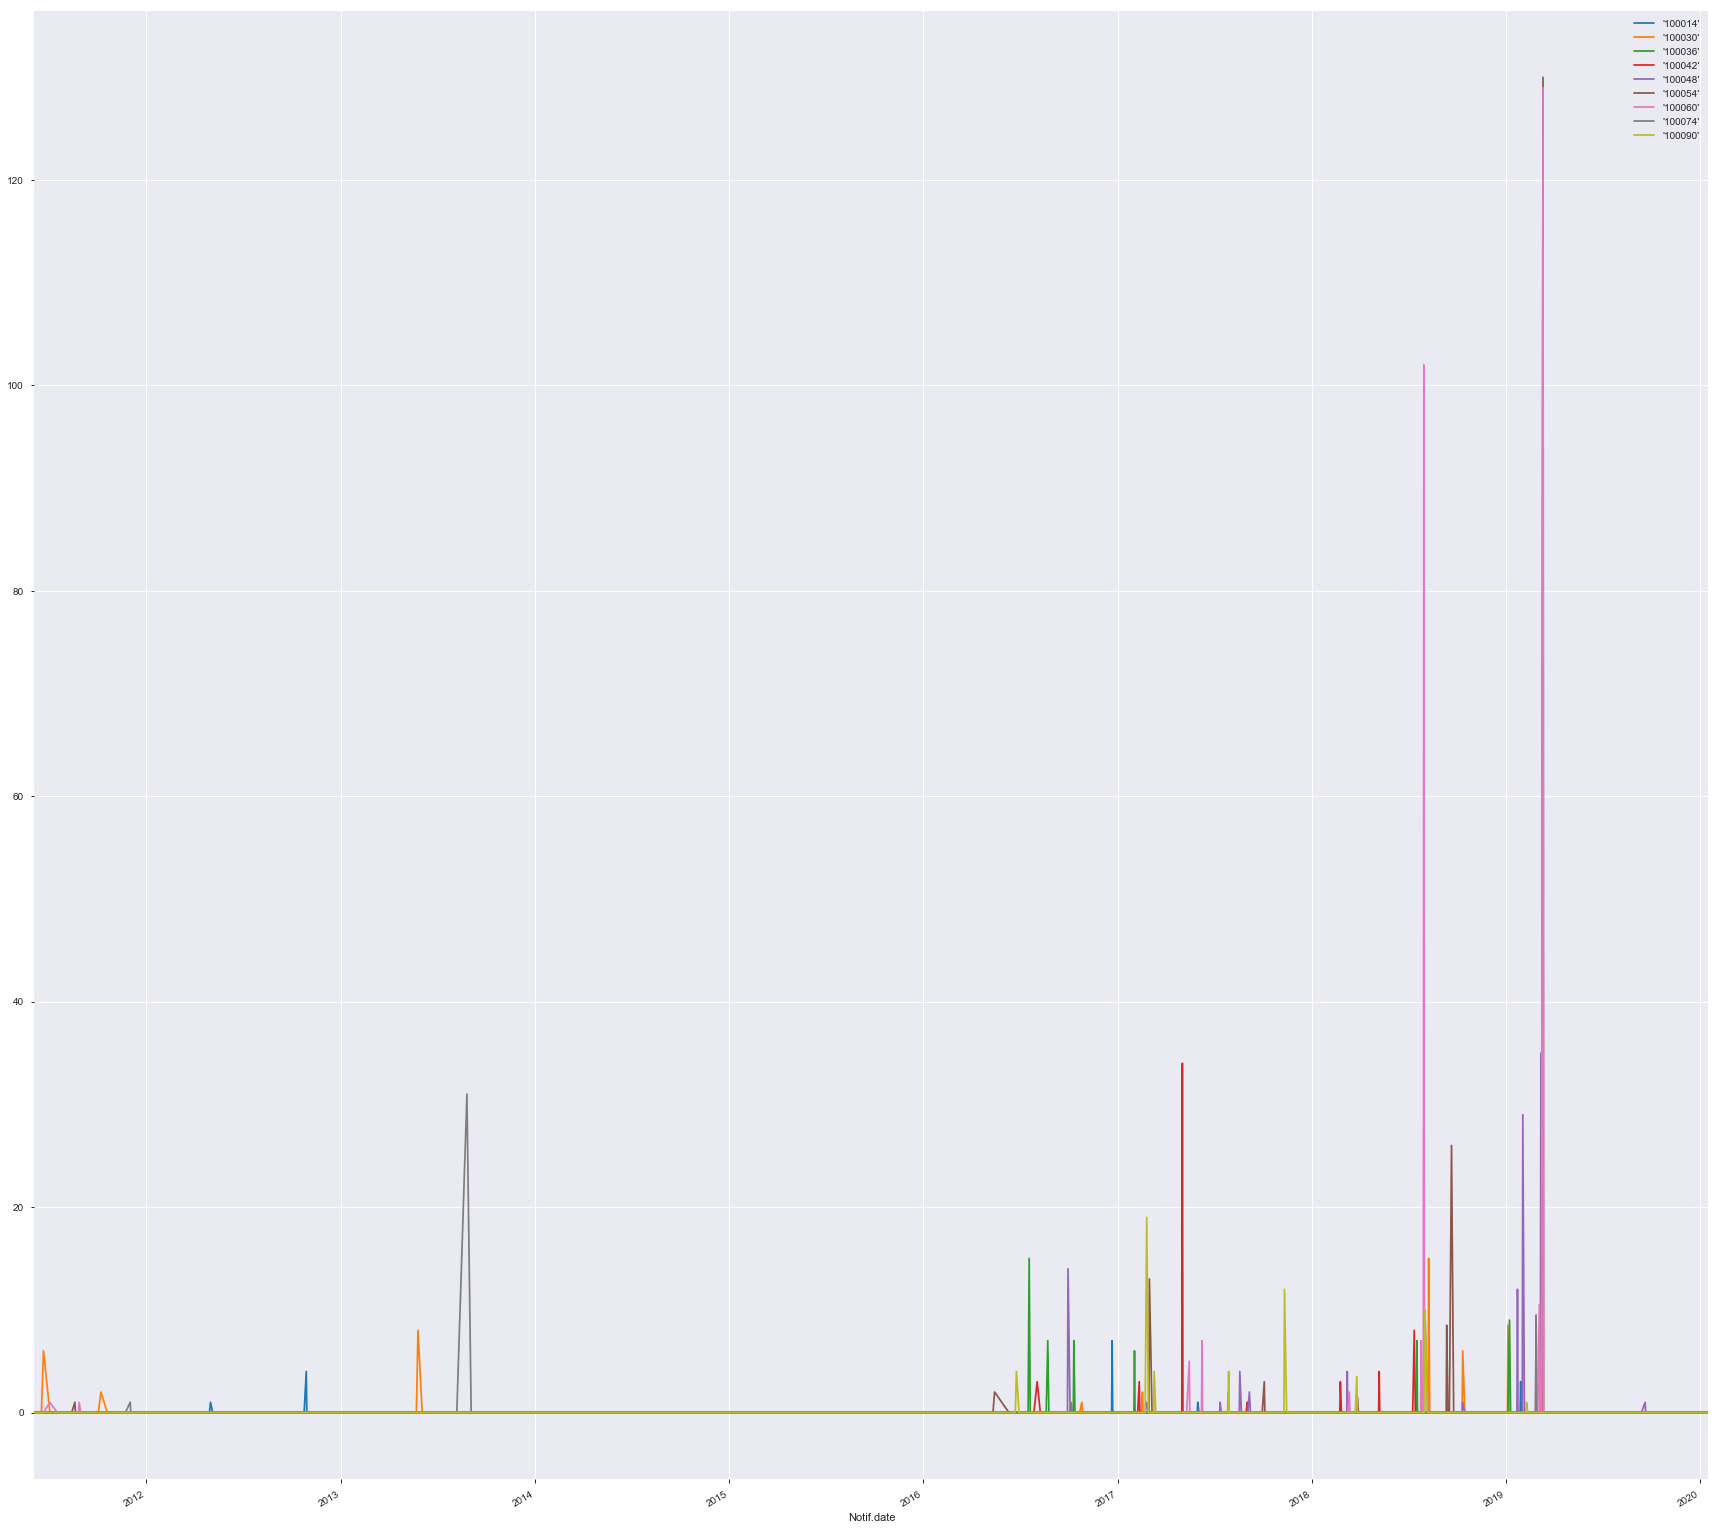

In [369]:
fig, ax = plt.subplots(figsize=(30,30))
f1.plot(ax=ax)

In [370]:
train=flattened_t1.iloc[0:500,:]
test=flattened_t1.iloc[501:,:]

In [378]:
train=train.set_index('Notif.date')
test=test.set_index('Notif.date')

In [384]:
from sklearn.preprocessing import MinMaxScaler
import joblib
scaler = MinMaxScaler()
X_train= scaler.fit_transform(train)
X_test=scaler.transform(test)
scalet_filename="scaler_data"
joblib.dump(scaler,scalet_filename)


['scaler_data']

In [385]:
X_train=X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test=X_test.reshape(X_test.shape[0],1,X_test.shape[1])

## Autoencoder

In [392]:
#reference - https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6
def autoencoder_model(x):
    inputs=Input(shape=(x.shape[1],x.shape[2]))
    l1=LSTM(16,activation='relu',return_sequences=True,
            kernel_regularizer=regularizers.l2(0.00))(inputs)
    l2=LSTM(4,activation='relu',return_sequences=False)(l1)
    l3=RepeatVector(x.shape[1])(l2)
    l4=LSTM(4,activation='relu',return_sequences=True)(l3)
    l5=LSTM(16,activation='relu',return_sequences=True)(l4)
    output=TimeDistributed(Dense(x.shape[2]))(l5)
    model=Model(inputs=inputs,outputs=output)
    return model

In [393]:
model=autoencoder_model(X_train)
model.compile(optimizer='adam',loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 341)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             22912     
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 341)            5797

In [401]:
batch_size=10
history=model.fit(X_train,X_train,nb_epoch=100, 
                  batch_size=batch_size,validation_split=0.05).history

/Users/soujanyasamineni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 475 samples, validate on 25 samples
Epoch 1/100
475/475 [==============================] - 2s 5ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 2/100
475/475 [==============================] - 0s 497us/step - loss: 0.0022 - val_loss: 0.0039
Epoch 3/100
475/475 [==============================] - 0s 483us/step - loss: 0.0021 - val_loss: 0.0039
Epoch 4/100
475/475 [==============================] - 0s 443us/step - loss: 0.0021 - val_loss: 0.0039
Epoch 5/100
475/475 [==============================] - 0s 495us/step - loss: 0.0021 - val_loss: 0.0039
Epoch 6/100
475/475 [==============================] - 0s 467us/step - loss: 0.0022 - val_loss: 0.0039
Epoch 7/100
475/475 [==============================] - 0s 484us/step - loss: 0.0022 - val_loss: 0.0039
Epoch 8/100
475/475 [==============================] - 0s 432us/step - loss: 0.0021 - val_loss: 0.0039
Epoch 9/100
475/475 [==============================] - 0s 530us/step - loss: 0.0021 - val_loss: 0.0039
Epoch 10/100
475/475 [========

In [1]:
# fig,ax=plt.subplots(figsize=(14,6), dpi=80)
# ax.plot(history['loss'],'b',label='Train',linewidth=2)
# ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
# ax.set_title("Loss",fontsize=12)
# ax.set_ylabel("MAE")
# ax.set_xlabel("Epoch")
# ax.legend(loc="upper right")
# plt.show()

## Set threshold

(0.0, 0.02)

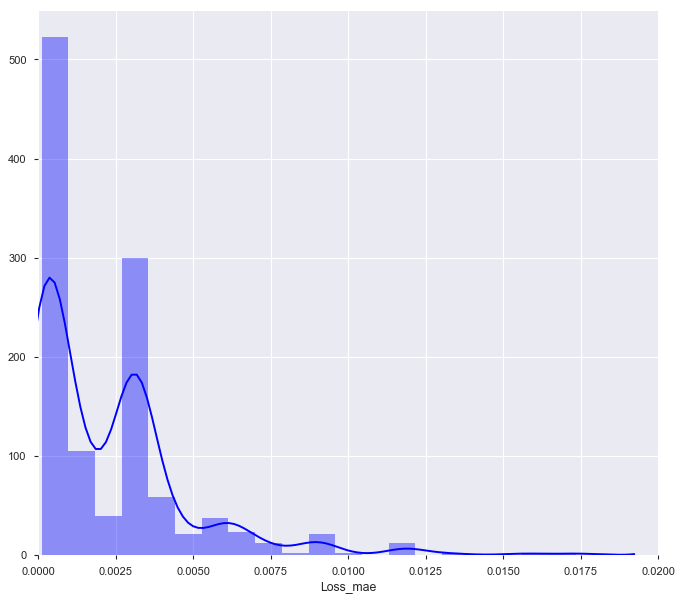

In [413]:
X_pred=model.predict(X_train)
X_pred=X_pred.reshape(X_pred.shape[0],X_pred.shape[2])
X_pred=pd.DataFrame(X_pred,columns=train.columns)
X_pred.index=train.index
scored=pd.DataFrame(index=train.index)
Xtrain=X_train.reshape(X_train.shape[0],X_train.shape[2])
scored['Loss_mae']=np.mean(np.abs(X_pred-Xtrain),axis=1)
plt.figure(figsize=(10,9),dpi=80)
sns.distplot(scored['Loss_mae'],bins=20,kde=True,color='b');
plt.xlim([0.0,.02])

## Test and plot

In [465]:
#threshold of anomaly 0.01; loss on test set
X_pred=model.predict(X_test)
X_pred
X_pred=X_pred.reshape(X_pred.shape[0],-1)
X_pred=pd.DataFrame(X_pred,columns=test.columns)
X_pred.index=test.index

scored=pd.DataFrame(index=test.index)
Xtest=X_test.reshape(X_test.shape[0],X_test.shape[2])
scored['Loss_mae']=np.mean(np.abs(X_pred-Xtest),axis=1)
scored['Threshold']=0.0003 # can be altered
scored['Anomaly']=scored['Loss_mae']>scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Notif.date,,,
2018-07-17,0.001477,0.0003,True
2018-07-18,0.000109,0.0003,False
2018-07-19,0.000258,0.0003,False
2018-07-20,0.325622,0.0003,True
2018-07-23,0.000109,0.0003,False


In [466]:
scored.head()

,Loss_mae,Threshold,Anomaly
Notif.date,,,
2018-07-17,0.001477,0.0003,True
2018-07-18,0.000109,0.0003,False
2018-07-19,0.000258,0.0003,False
2018-07-20,0.325622,0.0003,True
2018-07-23,0.000109,0.0003,False


In [467]:
#calculate for entire dataset
X_pred_train=model.predict(X_train)
X_pred_train=X_pred_train.reshape(X_pred_train.shape[0],X_pred_train.shape[2])
X_pred_train=pd.DataFrame(X_pred_train,columns=train.columns)
X_pred_train.index=train.index
scored_train=pd.DataFrame(index=train.index)
scored_train['Loss_mae']=np.mean(np.abs(X_pred_train-Xtrain),axis=1)
scored_train['Threshold']=0.0003 # can be altered
scored_train['Anomaly']=scored_train['Loss_mae']>scored_train['Threshold']
scored=pd.concat([scored_train,scored])

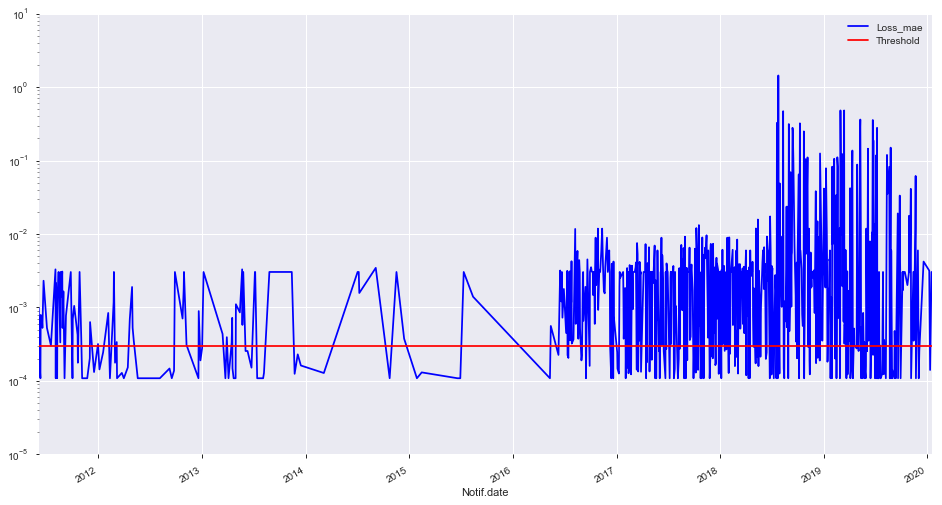

In [468]:
scored.plot(logy=True, figsize=(16,9),ylim=[1e-5,1e1],color=['blue','red'])